In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import legend
from scipy.ndimage import label
from scipy.stats import linregress
import yfinance as yf
import warnings

from sympy.stats import density

warnings.filterwarnings('ignore')
import sys
from datetime import datetime
import gdown  # For downloading files from Google Drive
import seaborn as sns
from scipy.stats import gaussian_kde

In [2]:
# Google Drive links (use the file ID for each dataset)
nav_url = 'https://drive.google.com/uc?id=1uJzV8wy1CwPzymIYnIhY8SzLojy55GoE'
sp500_url = 'https://drive.google.com/uc?id=1vZbBXwVBPaJGLrzmDtKSCAtHDQAC_F_6'
rfr_url = 'https://drive.google.com/uc?id=1MPR4ag3cdVSoI9bnFXOhSsXEw9k0QzzY'
portfolio_url = 'https://drive.google.com/uc?id=1LU2Ea2705MojdpoDk4KXyAN-rNgt3eOA'
sp_sector_url = 'https://drive.google.com/uc?id=1X7s_bIH-IKPrzAu-JrLg4vxFGmzVJSFC'

# Download and load datasets
gdown.download(nav_url, 'SMF_NAV_2024-12-01.csv', quiet=False)
gdown.download(sp500_url, 'SPX_data.csv', quiet=False)
gdown.download(rfr_url, 'Risk_Free_Rate.csv', quiet=False)
gdown.download(portfolio_url, 'Current_Portfolio_2024-12-01.csv', quiet=False)
gdown.download(sp_sector_url, 'SPX_Sector_Weight.csv', quiet=False)

# Load data into DataFrames
data = pd.read_csv('SMF_NAV_2024-12-01.csv')
sp500 = pd.read_csv('SPX_data.csv')
rfr = pd.read_csv('Risk_Free_Rate.csv')
portfolio = pd.read_csv('Current_Portfolio_2024-12-01.csv')
sp_sector_allocation = pd.read_csv('SPX_Sector_Weight.csv')

# Confirm data loaded
print("Data successfully loaded:")
print(f"Data: {data.shape}")
print(f"SP500: {sp500.shape}")
print(f"RFR: {rfr.shape}")
print(f"Portfolio: {portfolio.shape}")
print(f"SP Sector: {sp_sector_allocation.shape}")


Downloading...
From: https://drive.google.com/uc?id=1uJzV8wy1CwPzymIYnIhY8SzLojy55GoE
To: /Users/jeronimoperezrocha/PycharmProject/Investment-Analysis/SMF_NAV_2024-12-01.csv
100%|██████████| 140k/140k [00:00<00:00, 4.51MB/s]
Downloading...
From: https://drive.google.com/uc?id=1vZbBXwVBPaJGLrzmDtKSCAtHDQAC_F_6
To: /Users/jeronimoperezrocha/PycharmProject/Investment-Analysis/SPX_data.csv
100%|██████████| 48.3k/48.3k [00:00<00:00, 1.08MB/s]
Downloading...
From: https://drive.google.com/uc?id=1MPR4ag3cdVSoI9bnFXOhSsXEw9k0QzzY
To: /Users/jeronimoperezrocha/PycharmProject/Investment-Analysis/Risk_Free_Rate.csv
100%|██████████| 48.0k/48.0k [00:00<00:00, 4.32MB/s]
Downloading...
From: https://drive.google.com/uc?id=1LU2Ea2705MojdpoDk4KXyAN-rNgt3eOA
To: /Users/jeronimoperezrocha/PycharmProject/Investment-Analysis/Current_Portfolio_2024-12-01.csv
100%|██████████| 3.01k/3.01k [00:00<00:00, 3.69MB/s]
Downloading...
From: https://drive.google.com/uc?id=1X7s_bIH-IKPrzAu-JrLg4vxFGmzVJSFC
To: /Users/j

Data successfully loaded:
Data: (2650, 5)
SP500: (2562, 2)
RFR: (2546, 2)
Portfolio: (94, 4)
SP Sector: (29, 2)


# SMF Portfolio Analysis

This code was created to help SMF students get familiar with the portfolio. The tool is divided by Three sections, Performance, Sector Allocation and risk metrics. Read Chapeter 15 QEPM for reference

Note: If you are interested in adding or modifying the code please make a copy of this, do not modify this verion of the code. Alos the data sources have to be updated so you have the current data of the porftfolio as well as the prices of each stock and the sector allocation of the spx.

Any questions regarding the code plese contact me:
jperezrochasolorzano@dons.usfca.edu or
jperezrochas02@gmail.com

## Data Cleaning





In [3]:
#convert data sets to the same date format
sp500['Date'] = pd.to_datetime(sp500['Date'])
data['Date'] = pd.to_datetime(data['Date'], format='%Y%m%d')
rfr['Date'] = pd.to_datetime(rfr['Date'])
sp_sector_weight = sp_sector_allocation.dropna()


#Find common dates SPX with IBKR (IBKR Includes Holidays in their reports)
common_dates = set(sp500['Date']).intersection(set(data['Date']))
sp500_filtered = sp500[sp500['Date'].isin(common_dates)]
data_filtered = data[data['Date'].isin(common_dates)]

#Merge IBKR data and SPX based on common dates (only trading days)
df = pd.merge(sp500_filtered, data_filtered, on='Date', how='inner')

#Same for Risk Free Rate
common_dates1 = set(df['Date']).intersection(set(rfr['Date']))


df_filtered = df[df['Date'].isin(common_dates1)]
rfr_filtered = rfr[rfr['Date'].isin(common_dates1)]

#Combine Risk Free Rate with the other two data sources
merged_df = pd.merge(df_filtered, rfr_filtered, on='Date', how='inner')


#Make the first date oct 22 2014 avoid deposits and drop the NAN value after, and our starting date becomes 10-23-2014
pa = merged_df.sort_values('Date')
pa = pa.set_index('Date')
pa = pa.loc['2014-10-22': ]

 
 #Rename Riks Free Rate & SPX Column
pa.rename(columns={'Risk_Free_Rate': 'rfr'}, inplace=True)
pa.rename(columns={'Price': 'SPX'}, inplace=True)


## Performance

For performnace we will be using the Diezt Method, that takes into consideration the Cash Flows of the Portfolio use The dietz to calculate everything to have the most accurate metrics

In [4]:
# Calculate Equity value
pa['Equity'] = pa['Stocks'] + pa['ETFs']

# Calculate changes in Equity and Cash
pa['Change In Equity Value'] = pa['Equity'].diff()
pa['Change In Cash'] = pa['Cash'].diff()

# Calculate net cash flow (CF)
pa['CF'] = pa['Change In Equity Value'] + pa['Change In Cash']

# Calculate Vt for Dietz return calculation
pa['Vt'] = pa['Equity'].shift(1) + (0.5 * pa['CF'])

# Dietz return calculation
pa['dietzr'] = pa['CF'] / pa['Vt']

#Calculate returns
pa['spxr'] = np.log(pa['SPX'] / pa['SPX'].shift(1))
pa['NAVr'] = np.log(pa['NAV'] / pa['NAV'].shift(1))
pa['rfrr'] = np.log(pa['rfr'] / pa['rfr'].shift(1)) 

#Create an index for graphing
#Create an Index. The index normalized the data from plotting
pa['dietzIndex'] = 100 * np.exp(np.nan_to_num(pa['dietzr'].cumsum()))
pa['spxIndex'] = 100 * np.exp(np.nan_to_num(pa['spxr'].cumsum()))
pa['navIndex'] = 100 * np.exp(np.nan_to_num(pa['NAVr'].cumsum()))

#10-23-2014 to be our starting date, and remove nan
pa = pa.dropna()


#Avg Daily Returns
port_avg = np.mean(pa['dietzr'])
spx_avg = np.mean(pa['spxr'])

In [5]:
#Avg Daily Returns
print(f'Portfolio Average Daily Returns: {port_avg:.2%}')
print()
print(f'S&P 500 Average Daily Retunrs: {spx_avg:.2%}')



Portfolio Average Daily Returns: 0.05%

S&P 500 Average Daily Retunrs: 0.05%


In [6]:
def calculate_yearly_returns(daily_returns_dict):
    '''
    Calculate yearly returns for time series
     
    '''
    
    yearly_returns = {}
    
    for name, returns in daily_returns_dict.items():
        yearly_returns[name] = returns.resample('Y').apply(lambda x: (1+x).prod()-1)
        
    return pd.DataFrame(yearly_returns)

returns_data = {
    'Portfolio' : pa['dietzr'],
    'SPX' : pa['spxr']
}

yearly_returns = calculate_yearly_returns(returns_data)
df = yearly_returns[['Portfolio','SPX']] = yearly_returns[['Portfolio','SPX']].applymap('{:.2%}'.format)
print(df)

           Portfolio      SPX
Date                         
2014-12-31     6.08%    6.70%
2015-12-31   -12.31%   -1.91%
2016-12-31    20.74%    8.60%
2017-12-31    10.43%   19.15%
2018-12-31   -12.91%   -7.60%
2019-12-31    27.24%   27.87%
2020-12-31    26.98%    9.39%
2021-12-31    24.15%   25.80%
2022-12-31   -30.27%  -21.76%
2023-12-31    43.17%   23.17%
2024-12-31    31.28%   25.56%


In [7]:
yearly_returns = pa['dietzr'].resample('Y').apply(lambda x: (1+x).prod()-1)

spx_yearly_return = pa['spxr'].resample('Y').apply(lambda x: (1+x).prod() -1)

spx_yearly_return.map("{:.2%}".format)

Date
2014-12-31      6.70%
2015-12-31     -1.91%
2016-12-31      8.60%
2017-12-31     19.15%
2018-12-31     -7.60%
2019-12-31     27.87%
2020-12-31      9.39%
2021-12-31     25.80%
2022-12-31    -21.76%
2023-12-31     23.17%
2024-12-31     25.56%
Freq: A-DEC, Name: spxr, dtype: object

In [8]:
yearly_returns.map("{:.2%}".format)

Date
2014-12-31      6.08%
2015-12-31    -12.31%
2016-12-31     20.74%
2017-12-31     10.43%
2018-12-31    -12.91%
2019-12-31     27.24%
2020-12-31     26.98%
2021-12-31     24.15%
2022-12-31    -30.27%
2023-12-31     43.17%
2024-12-31     31.28%
Freq: A-DEC, Name: dietzr, dtype: object

In [9]:
# Calculate return since inception using Dietz method
dietz_return_inception = (pa['dietzIndex'].iloc[-1] - pa['dietzIndex'].iloc[0]) / pa['dietzIndex'].iloc[0]

print(f'Portfolio Return Since Inception (Dietz): {dietz_return_inception:.2%}')

# Calculate S&P 500 return since inception
spx_return_inception = (pa['spxIndex'].iloc[-1] - pa['spxIndex'].iloc[0]) / pa['spxIndex'].iloc[0]

print(f'S&P 500 Return Since Inception: {spx_return_inception:.2%}')

Portfolio Return Since Inception (Dietz): 250.79%
S&P 500 Return Since Inception: 209.22%


In [10]:
avg_year_returns = yearly_returns.mean()
print(f'Average Yearly Returns: {avg_year_returns:.2%}')

avg_spx_returns = spx_yearly_return.mean()
print(f'Average Yearly Returns: {avg_spx_returns:.2%}')

Average Yearly Returns: 12.23%
Average Yearly Returns: 10.45%


In [11]:
# Calculate tracking error using the daily returns (dietzr vs spxr)
# First get the difference in returns
return_difference = pa['NAVr'] - pa['spxr']

# Calculate tracking error (annualized)
# Multiply by sqrt(252) to annualize (assuming 252 trading days)
tracking_error = return_difference.std() * np.sqrt(252)

# Format as percentage
print(f'Tracking Error: {tracking_error:.2%}')



Tracking Error: 7.40%


# Risk Metrics

In [12]:
#beta since inception
port_beta = (linregress(y=pa['NAVr'], x=pa['spxr'])[0])

print(f'Portfolio Beta Since Inception: {port_beta}')

Portfolio Beta Since Inception: 1.0246680258202485


In [13]:
#5 year beta -- Last updated 10-25-2024
yr5 = pa.iloc[1209:]

yr5_beta = (linregress(y=yr5['NAVr'], x=yr5['spxr'])[0])

print(f'5 yeaer Beta: {yr5_beta}')

5 yeaer Beta: 1.0885407123926056


In [14]:
#beta for 3 years. Adjust depending the date
yr3 = pa.iloc[1712 : ] #Adjust depending the date

yr3_beta = (linregress(y=yr3['NAVr'], x=yr3['spxr'])[0])

print(f'3 year beta: {yr3_beta}')

3 year beta: 1.23846358121772


In [15]:
# 1 year beta
yr1 = pa.iloc[2243: ]

yr1_beta = (linregress(y=yr1['NAVr'], x=yr1['spxr'])[0])

print(f'1 year beta: {yr1_beta}')

1 year beta: 1.3043337320386041


In [16]:
#std of the portfolio since inception
std = np.std(pa['NAVr'])
print(f'STD since inception: {std:.2%}')

spx_std = np.std(pa['spxr'])
print(f'S&P 500: {spx_std:.2%}')

STD since inception: 1.24%
S&P 500: 1.13%


In [17]:
#STD by year
std_by_year = pa.groupby('year')['NAVr'].std()

std_by_year.map("{:.2%}".format)

KeyError: 'year'

In [327]:
#Semi STD
avg_dietzr = np.mean(pa['dietzr'])
below_avg = pa[pa['dietzr'] < avg_dietzr]
semi_std = below_avg['dietzr'].std(ddof=0)


#S&P 500 semi STD
avg_spxr = np.mean(pa['spxr'])
below_spx_avg = pa[pa['spxr'] < avg_spxr]
spx_semi_std = below_avg['spxr'].std(ddof=0)


print(f'Portfolio Semi std: {semi_std:.2%}')
print()
print(f'S&P 500 Semi std: {spx_semi_std:.2%}')

Portfolio Semi std: 1.05%

S&P 500 Semi std: 0.98%


In [328]:
#Variance and Correlation

cor = np.corrcoef(pa['spxr'], pa['dietzr'])[0,1]

cov = np.cov(pa['spxr'], pa['dietzr'])[0][1]

print(f"Correlation with spx: {cor:.4f}")
print()
print(f"Covariance with spx: {cov:.8f}")

Correlation with spx: 0.9290

Covariance with spx: 0.00014042


In [329]:
#sharpe ratio
excess_returns = pa['NAVr'] - pa['rfrr']
sharpe_ratio = np.mean(excess_returns) / np.std(excess_returns)

sp500_excess_returns = pa['spxr'] - pa['rfrr']
sp500_sharpe_ratio = np.mean(sp500_excess_returns) / np.std(sp500_excess_returns)


#5 year Sharpe ratio
yr5_excess = yr5['NAVr'] - yr5['rfrr']
sharpe_ratio5yr = np.mean(yr5_excess) / np.std(yr5_excess)

spx_5yr_excessr = yr5['NAVr'] - yr5['rfrr']
sp500_5yr_sharpe_ratio = np.mean(spx_5yr_excessr) / np.std(spx_5yr_excessr)


#3 year sharpe ratio
yr3_excess = yr3['NAVr'] - yr3['rfrr']
sharpe_ratio3yr = np.mean(yr3_excess) / np.std(yr3_excess)

spx_3yr_excess = yr3['spxr'] - yr3['rfrr']
sp_sharpe_ratio3yr = np.mean(spx_3yr_excess) / np.std(spx_3yr_excess)


#1yr Sharpe Ratio
yr1_excess = yr1['NAVr'] - yr1['rfrr']
sharpe_ratio1yr = np.mean(yr1_excess) / np.std(yr1_excess)

spx_1yr_excess = yr1['spxr'] - yr1['rfrr']
sp_sharpe_ratio1yr = np.mean(spx_1yr_excess) / np.std(spx_1yr_excess)


print(f'Portfolio Sharpe Ratio: {sharpe_ratio}')
print()
print(f'S&P 500 Sharpe Ratio: {sp500_sharpe_ratio}')

print('--------------------------------------------')

print(f'5 Year Sharpe Ratio: {sharpe_ratio5yr}')
print()
print(f'S&P 500 5 Year Sharpe Ratio:{sp500_5yr_sharpe_ratio}')

print('--------------------------------------------')

print(f'3 Year Sharpe Ratio {sharpe_ratio3yr}')
print()
print(f'S&P 500 3 Year Sharpe Ratio: {sp_sharpe_ratio3yr}')

print('--------------------------------------------')

print(f'1 Year Sharpe Ratio: {sharpe_ratio1yr}')
print()
print(f'S&P 500 Sharpe Ratio: {sp_sharpe_ratio1yr}')


Portfolio Sharpe Ratio: 0.03049871557590864

S&P 500 Sharpe Ratio: 0.03408639689993132
--------------------------------------------
5 Year Sharpe Ratio: 0.04155575769497399

S&P 500 5 Year Sharpe Ratio:0.04155575769497399
--------------------------------------------
3 Year Sharpe Ratio 0.02183341674856574

S&P 500 3 Year Sharpe Ratio: 0.019945926631160137
--------------------------------------------
1 Year Sharpe Ratio: 0.1068731106238082

S&P 500 Sharpe Ratio: 0.11981149479144622


In [330]:
#Information ratio
excess_returns1 = pa['NAVr'] - pa['spxr']

information_ratio = np.mean(excess_returns1) / np.std(excess_returns1)

print(f'Information Ratio: {information_ratio}')

Information Ratio: -0.0009442473677162112


In [331]:
#Treynor Ratio
avg_excess_return = np.mean(excess_returns)
treynor_ratio = avg_excess_return / port_beta


spx_avg_excess_returns = np.mean(excess_returns1)
sp_treynor_ratio = spx_avg_excess_returns / 1


# 5 year Treynor ratio - using existing yr5_beta
treynor_ratio5yr = np.mean(yr5_excess) / yr5_beta
spx_5yr_treynor = np.mean(spx_5yr_excessr) / 1

# 3 year Treynor ratio - using existing yr3_beta
treynor_ratio3yr = np.mean(yr3_excess) / yr3_beta
spx_3yr_treynor = np.mean(spx_3yr_excess) / 1

# 1 year Treynor ratio - using existing yr1_beta (if you have it)
treynor_ratio1yr = np.mean(yr1_excess) / yr1_beta
spx_1yr_treynor = np.mean(spx_1yr_excess) / 1

print(f'Portfolio Treynor Ratio: {treynor_ratio:.4f}')
print(f'S&P 500 Treynor Ratio: {sp_treynor_ratio:.4f}')

print('--------------------------------------------')

print(f'5 Year Treynor Ratio: {treynor_ratio5yr:.4f}')
print(f'S&P 500 5 Year Treynor Ratio: {spx_5yr_treynor:.4f}')

print('--------------------------------------------')

print(f'3 Year Treynor Ratio: {treynor_ratio3yr:.4f}')
print(f'S&P 500 3 Year Treynor Ratio: {spx_3yr_treynor:.4f}')

print('--------------------------------------------')

print(f'1 Year Treynor Ratio: {treynor_ratio1yr:.4f}')
print(f'S&P 500 1 Year Treynor Ratio: {spx_1yr_treynor:.4f}')






Portfolio Treynor Ratio: 0.0004
S&P 500 Treynor Ratio: -0.0000
--------------------------------------------
5 Year Treynor Ratio: 0.0006
S&P 500 5 Year Treynor Ratio: 0.0006
--------------------------------------------
3 Year Treynor Ratio: 0.0003
S&P 500 3 Year Treynor Ratio: 0.0002
--------------------------------------------
1 Year Treynor Ratio: 0.0009
S&P 500 1 Year Treynor Ratio: 0.0009


# Graphs


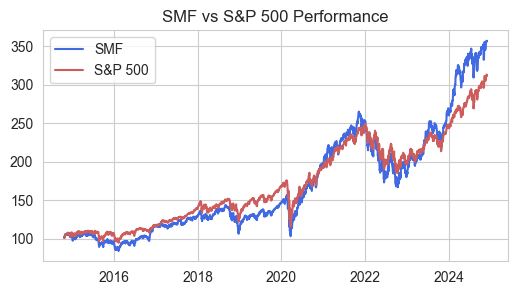

In [333]:
#Portfolio Performance Since Inception

plt.figure(figsize=(6,3))
plt.plot(pa.index, pa['dietzIndex'], color='royalblue',label='SMF')
plt.plot(pa.index, pa['spxIndex'], color='indianred', label='S&P 500')

plt.legend()
plt.title('SMF vs S&P 500 Performance')
plt.grid(True)


TypeError: 'str' object is not callable

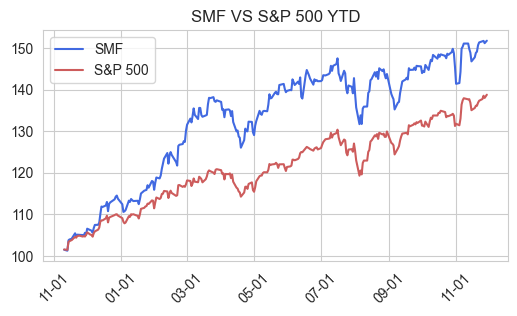

In [334]:
#Start Date
pa_2024 = pa.iloc[2260:]

#Create Index
pa_2024['dietzIndex_24'] = 100 * np.exp(np.nan_to_num(pa_2024['NAVr'].cumsum()))
pa_2024['spxIndex_24'] = 100 * np.exp(np.nan_to_num(pa_2024['spxr'].cumsum()))

# Create the plot
plt.figure(figsize=(6,3))
plt.plot(pa_2024.index, pa_2024['dietzIndex_24'], color='royalblue', label='SMF')
plt.plot(pa_2024.index, pa_2024['spxIndex_24'], color='indianred', label='S&P 500')

# Customize the plot
plt.title('SMF VS S&P 500 YTD')
plt.grid(True)
plt.legend()

# Format x-axis dates
from matplotlib.dates import DateFormatter
plt.gca().xaxis.set_major_formatter(DateFormatter('%m-%d'))  # Month-day format
plt.xticks(rotation=45)

# Remove x and y axis labels since they're self-explanatory
plt.xlabel('')
plt.ylabel('')

# Adjust layout to prevent date labels from being cut off
plt.tight_layout()

plt.show()

TypeError: 'str' object is not callable

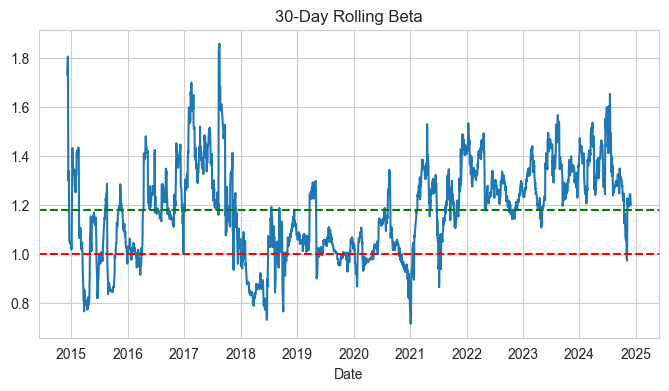

In [336]:
# Calculate rolling beta
rolling_covariance = pa['dietzr'].rolling(window=30).cov(pa['spxr'])
rolling_variance = pa['spxr'].rolling(window=30).var()
rolling_beta = rolling_covariance / rolling_variance

# Calculate average beta
average_beta = rolling_beta.mean()

# Create the plot using the Date column
plt.figure(figsize=(8, 4))
plt.plot(pa.index, rolling_beta, label='30-Day Rolling Beta')
plt.axhline(y=1, color='r', linestyle='--', label='Market Beta (β=1)')
plt.axhline(y=average_beta, color='g', linestyle='--', label=f'Average Beta (β={average_beta:.2f})')

# Format the plot
plt.title('30-Day Rolling Beta')
plt.xlabel('Date')
plt.ylabel('Beta')
plt.legend()
plt.grid(True)




plt.show()

In [ ]:
# Calculate rolling means first
rolling_spxr_mean = pa['spxr'].rolling(window=30).mean()
rolling_portr_mean = pa['dietzr'].rolling(window=30).mean()
rolling_rfrr_mean = pa['rfrr'].rolling(window=30).mean()

#calculate excess returns
rolling_excessr_port = rolling_portr_mean - rolling_rfrr_mean
rolling_excessr_spx = rolling_spxr_mean - rolling_rfrr_mean

# Calculate rolling standard deviations for Sharpe ratio
rolling_std_port = pa['dietzr'].rolling(window=30).std()
rolling_std_spx = pa['spxr'].rolling(window=30).std()

# Calculate rolling Sharpe ratios
port_rolling_sharpe = (rolling_excessr_port / rolling_std_port) * np.sqrt(252)
spx_rolling_sharpe = (rolling_excessr_spx / rolling_std_spx) * np.sqrt(252)


avg_rolling = port_rolling_sharpe.mean()

# Create the plot
plt.figure(figsize=(8,4))
plt.plot(pa['Date'], port_rolling_sharpe, label="Portfolio Sharpe Ratio")
plt.axhline(y=avg_rolling, color='g', linestyle='--', label=f'Average Sharpe Ratio {average_beta:.2f}')

# Customize the plot
plt.title('30-Day Rolling Sharpe Ratio', fontsize=12, pad=15)
plt.xlabel('Date')
plt.ylabel('Sharpe Ratio')
plt.legend()
plt.grid(True, alpha=0.3)


plt.tight_layout()
plt.show()


In [ ]:
# Calculate excess returns
excess_returns = pa['dietzr'] - pa['rfrr']

# Calculate 30-day rolling beta and mean excess returns
rolling_covariance = pa['dietzr'].rolling(window=30).cov(pa['spxr'])
rolling_variance = pa['spxr'].rolling(window=30).var()
rolling_beta = rolling_covariance / rolling_variance

rolling_excess_returns = excess_returns.rolling(window=30).mean()

# Calculate rolling Treynor ratio
rolling_treynor = rolling_excess_returns / rolling_beta

# Annualize the Treynor ratio
rolling_treynor_annual = rolling_treynor * 252

# Create the plot
plt.figure(figsize=(8,4))
plt.plot(pa['Date'], rolling_treynor_annual, label="Rolling Treynor Ratio")
plt.axhline(y=rolling_treynor_annual.mean(), color='r', linestyle='--',
            label=f'Average Treynor Ratio {rolling_treynor_annual.mean():.2f}')

# Customize the plot
plt.title('30-Day Rolling Treynor Ratio)', fontsize=12, pad=15)
plt.xlabel('Date')
plt.ylabel('Treynor Ratio')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

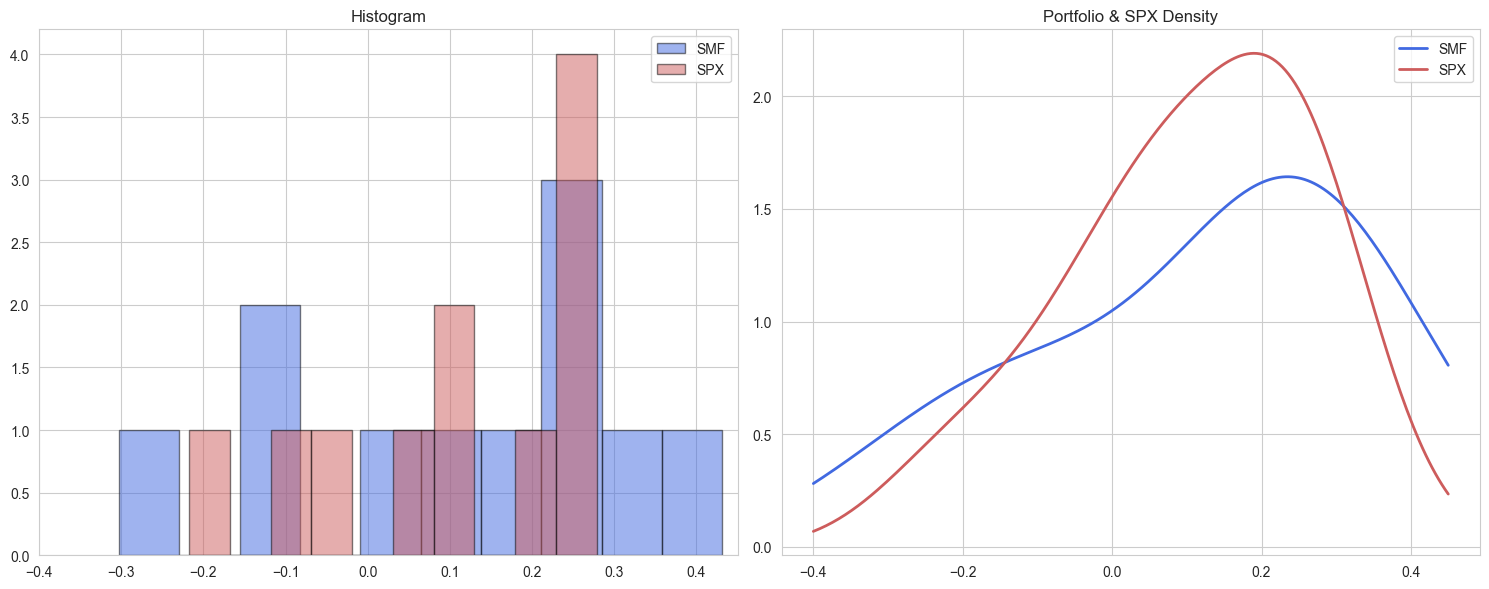

In [338]:
#Yearly Returns
yearly_smf = pa['dietzr'].resample('Y').apply(lambda x: (1 + x).prod() - 1) 
yearly_spx = pa['spxr'].resample('Y').apply(lambda x: (1 + x).prod() - 1)

yearly_ret = pd.merge(yearly_smf, yearly_spx, on='Date')

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(15,6))
ax1.hist(yearly_ret['dietzr'], color='royalblue', bins=10, label='SMF', alpha=0.5, edgecolor='black')
ax1.hist(yearly_ret['spxr'], color='indianred', bins=10, label ='SPX', alpha=0.5, edgecolor='black')
ax1.legend()
ax1.set_xlim(-0.40, 0.45)
ax1.set_title('Histogram')


for data, color, label in [(yearly_ret['dietzr'], 'royalblue', 'SMF'), (yearly_ret['spxr'], 'indianred', 'SPX')]:
    density = gaussian_kde(data)
    xs = np.linspace(-0.40, 0.45, 200)
    plt.plot(xs, density(xs), color=color, lw=2, label=label)
    plt.title('Portfolio & SPX Density')
    
plt.legend()
plt.grid(True)
plt.tight_layout()

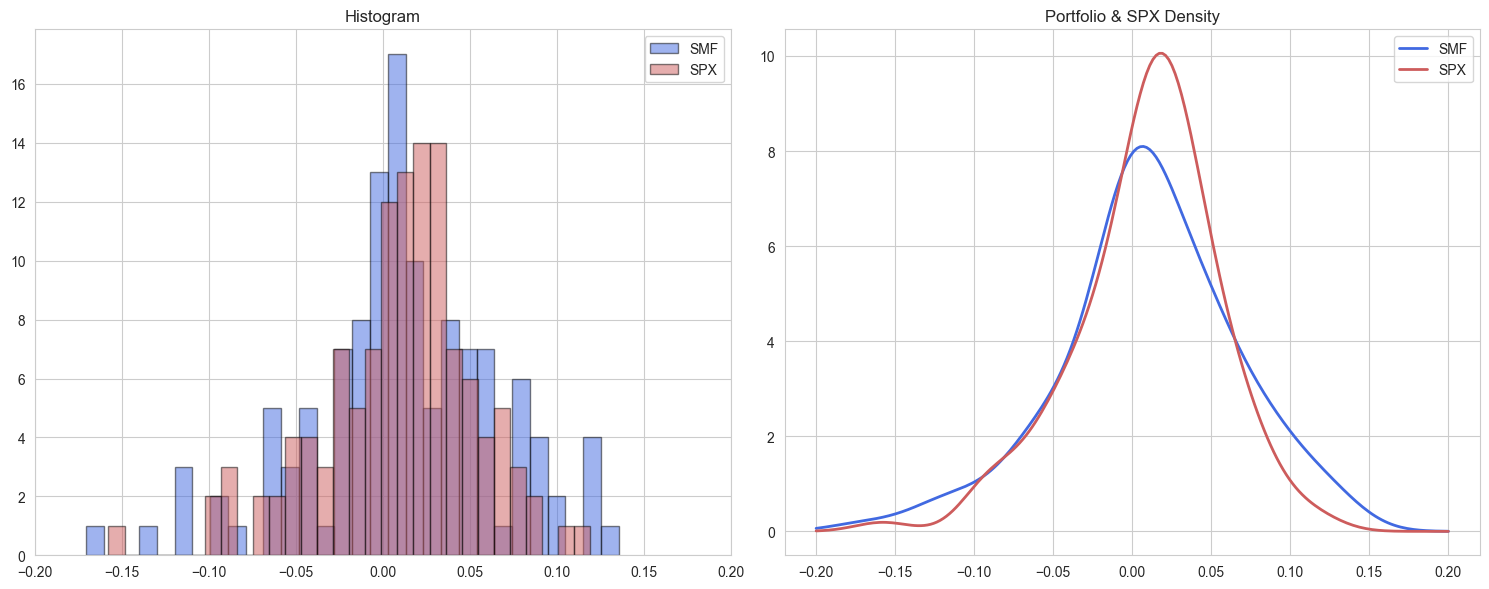

In [308]:
#Monthly Retunrs & Plots
monthly_smf = pa['dietzr'].resample('M').apply(lambda x: (1 + x).prod() - 1)
monthly_spx = pa['spxr'].resample('M').apply(lambda x: (1 + x).prod() - 1)


monthly_ret = pd.merge(monthly_smf, monthly_spx, on='Date')

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(15,6))
ax1.hist(monthly_ret['dietzr'], color='royalblue', bins=30, label='SMF', alpha=0.5, edgecolor='black')
ax1.hist(monthly_ret['spxr'], color='indianred', bins=30, label ='SPX', alpha=0.5, edgecolor='black')
ax1.legend()
ax1.set_xlim(-0.20, 0.20)
ax1.set_title('Histogram')


for data, color, label in [(monthly_ret['dietzr'], 'royalblue', 'SMF'), (monthly_ret['spxr'], 'indianred', 'SPX')]:
    density = gaussian_kde(data)
    xs = np.linspace(-0.20, 0.20, 200)
    plt.plot(xs, density(xs), color=color, lw=2, label=label)
    plt.title('Portfolio & SPX Density')
    
plt.legend()
plt.grid(True)
plt.tight_layout()

In [ ]:
portfolio['value'] = portfolio['Quantity'] * portfolio['Price']

portfolio_value = portfolio['value'].sum()

print(f'Portfolio Value: ${portfolio_value:,.2f}')

In [ ]:
#Value by sector

weight_sector = portfolio.groupby('Sector').agg(
    value = ('value', 'sum')
)


weight = weight_sector['value'] / portfolio_value

weight.map("{:.2%}".format)

In [ ]:
#Top 10 holdings
top_5 = portfolio[['Symbol', 'value', 'Sector']].sort_values(by='value', ascending=False)
top_5.head(5)

In [ ]:
sector_values = portfolio.groupby('Sector')['value'].sum()

# Create pie chart
plt.figure(figsize=(10, 8))
plt.pie(sector_values, labels=sector_values.index, autopct='%1.1f%%')
plt.title('Portfolio Distribution by Sector')
plt.axis('equal')
plt.show()

In [ ]:
spsector_value = sp_sector_weight.groupby('Name')['Weight'].sum()

plt.figure(figsize=(10,8))
plt.pie(spsector_value, labels=spsector_value.index, autopct='%1.1f%%')
plt.title('S&P 500 Sector Weight Allocation')
plt.axis('equal')
plt.show()